# Heritage Health Prize, alternate take
The full dataset is comprised of 5 tables as follows:


1. Members Table, which will include:
    1. MemberID (a unique member ID)
    2. AgeAtFirstClaim (member's age when first claim was made in the Data Set period)
    3. Sex


2. Claims Table, which will include:
    1. MemberID
    2. ProviderID (the ID of the doctor or specialist providing the service)
    3. Vendor (the company that issues the bill)
    4. PCP (member's primary care physician)
    5. Year (the year of the claim, Y1, Y2, Y3)
    6. Specialty
    7. PlaceSvc (place where the member was treated)
    8. PayDelay (the delay between the claim and the day the claim was paid for)
    9. LengthOfStay
    10. DSFS (days since first service that year)
    11. PrimaryConditionGroup (a generalization of the primary diagnosis codes)
    12. CharlsonIndex (a generalization of the diagnosis codes in the form of a categorized comorbidity score)
    13. ProcedureGroup (a generalization of the CPT code or treatment code)
    14. SupLOS (a flag that indicates if LengthOfStay is null because it has been suppressed)


3. Labs Table, which will contain certain details of lab tests provided to members.


4. RX Table, which will contain certain details of prescriptions filled by members.


5. DaysInHospital Tables - Y2, Y3 and Y4, which will contain the number of days of hospitalization for each eligible member during Y2 and Y3 and will include:
    1. MemberID;
    2. ClaimsTruncated (a flag for members who had claims suppressed in the previous year. If the flag is 1 for member xxx in DaysInHospital_Y2, some claims for member xxx will have been suppressed in Y1).
    3. DaysInHospital (the number of days in hospital Y2 or Y3, as applicable).
    
**Note:** Because this was a Kaggle competition, I do not have "DaysInHospital" data for Y4.  This was the target to be predicted for the Kaggle competition.  Instead, I modified the goal so that claims from Y1 and Year 2 will be used to predict days in hospital for Y3.

__Performance measure__

Model performance is reported in terms of the `HHPError` which is defined below.

The [HHP prediction accuracy measure](https://www.heritagehealthprize.com/c/hhp/details/evaluation) is the log root-mean-squared-error (log RMSE) loss function, known as the **HHPError**

\begin{equation}
HHPError = \sqrt{\frac{1}{n}\displaystyle\sum_{i=1}^{n}{[log(p_i + 1) - log(a_i + 1)]\,^2}}
\end{equation}

where 
1.  $i$ is a member;  
2.  $n$ is the total number of members;  
3.  $p_i$ is the predicted number of days spent in the hospital for member $i$ in the test period;  
4.  $a_i$ is the actual number of days spent in the hospital for member $i$ in the test period. 


# Import modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.6f}'.format
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from xgboost import XGBRegressor
from tempfile import mkdtemp
from shutil import rmtree

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.utils import check_array
from sklearn_pandas import CategoricalImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.dummy import DummyRegressor

from time import time

%matplotlib inline

np.set_printoptions(threshold = np.inf, suppress = True)
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:78% !important; }</style>"))

# Import raw data

In [79]:
# Load raw data

dataDir = os.path.join('s3://tdp-ml-datasets/misc/HeritageHealthPrize')

def loadData(inPath, name, showDetail = False):
    df = pd.read_csv(inPath)
    if showDetail:
        print(df.info())
        display(df.head(2))
        print()
    return df

dfTargetY2 = loadData(os.path.join(dataDir, 'DaysInHospital_Y2.csv'), 'target_Y2')
dfTargetY3 = loadData(os.path.join(dataDir, 'DaysInHospital_Y3.csv'), 'target_Y3')
dfClaims = loadData(os.path.join(dataDir, 'Claims.csv'), 'claims')
dfDrugCount = loadData(os.path.join(dataDir, 'DrugCount.csv'), 'drug_count')
dfLabCount = loadData(os.path.join(dataDir, 'LabCount.csv'), 'lab_count')
dfMembers = loadData(os.path.join(dataDir, 'Members.csv'), 'members')


# Preliminary EDA

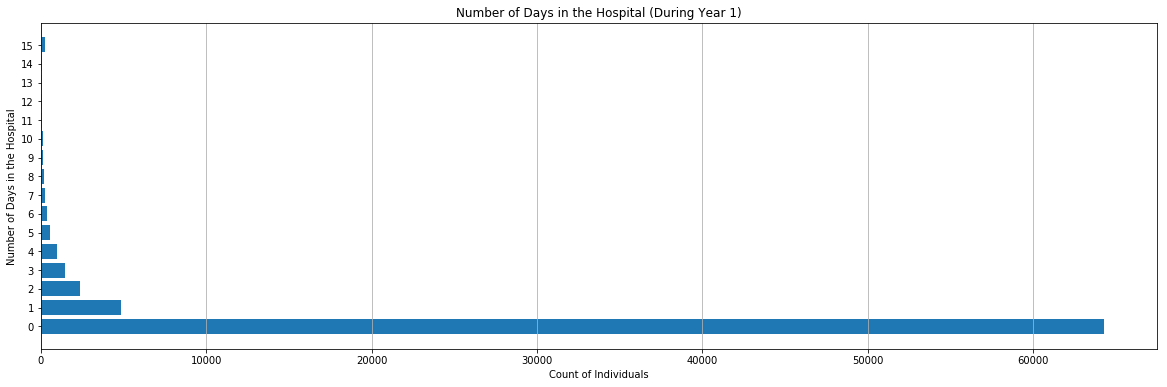

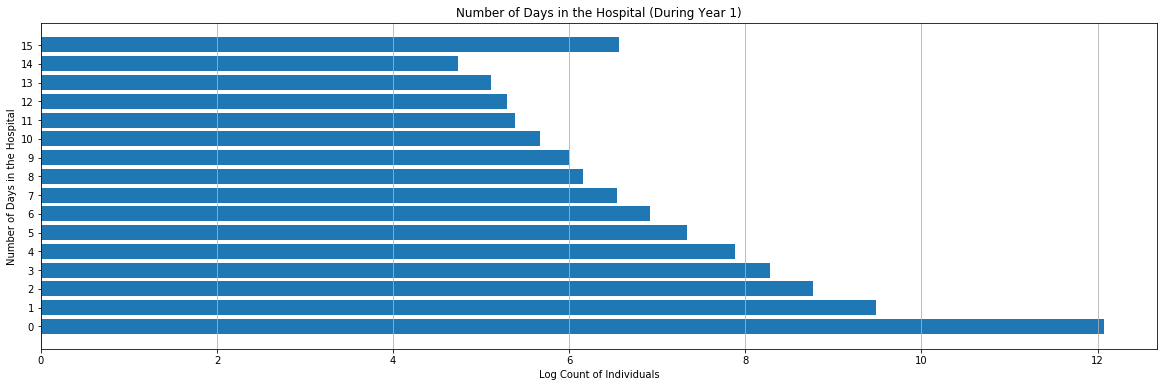

In [13]:
# Visualize Days In Hopsital following year 1

days = dfTargetY2['DaysInHospital'].unique()
days.sort()
inds = dfTargetY2['DaysInHospital'].value_counts(dropna = False).sort_index()

plt.figure(figsize=(20,6))
plt.barh(days,inds)
plt.grid(b = None, which = 'major', axis = 'x')

plt.yticks(range(0,16),range(0,16))
plt.ylabel('Number of Days in the Hospital')
plt.xlabel('Count of Individuals')
plt.title('Number of Days in the Hospital (Following Year 1)');

# log transform count
inds = np.log(inds) + 1

plt.figure(figsize=(20,6))
plt.barh(days,inds)
plt.grid(b = None, which = 'major', axis = 'x')

plt.yticks(range(0,16),range(0,16))
plt.ylabel('Number of Days in the Hospital')
plt.xlabel('Log Count of Individuals')
plt.title('Number of Days in the Hospital (Following Year 1)');


>Log +1 transformation of the unique value counts corrects the extreme skew toward individuals who spent zero days in the hospital

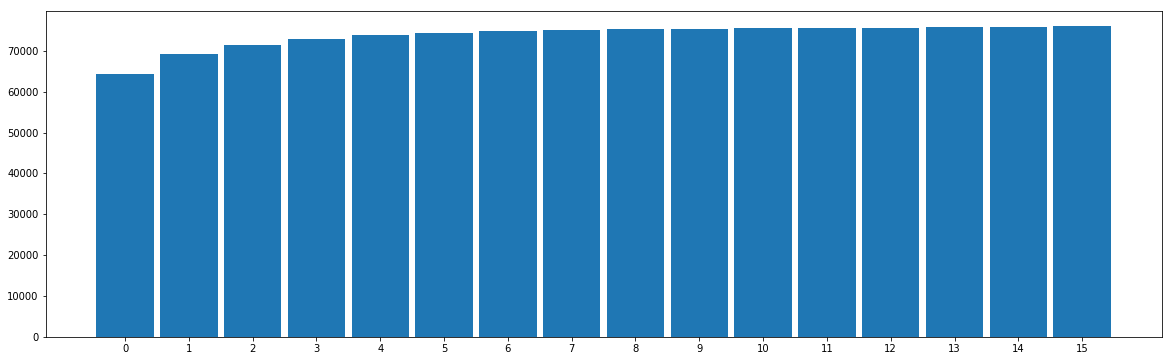

In [15]:
# Cumulatie bar chart visualizing Days In Hospital

days = dfTargetY2['DaysInHospital'].unique()
days.sort()
inds = dfTargetY2['DaysInHospital'].value_counts(dropna = False).sort_index()

plt.figure(figsize = (20,6))

plt.hist(x = dfTargetY2['DaysInHospital']
         ,bins = np.arange(17) - 0.5
         ,density = False
         ,histtype = 'bar'
         ,align = 'mid'
         ,rwidth = 0.9
         ,cumulative = True)
plt.xticks(range(0,16),range(0,16))
plt.show()


>The vast majority of individuals stayed in hospital 0 days

In [80]:
# Add log of target to form the label

dfTargetY2['label'] = np.log(dfTargetY2['DaysInHospital'] + 1)
dfTargetY3['label'] = np.log(dfTargetY3['DaysInHospital'] + 1)

# Add column for year of the associated claims, so that records can be differentiated 

dfTargetY2['Year'] = 'Y1'
dfTargetY3['Year'] = 'Y2'

# inner join of df_claims and df_target_Y2

merged = pd.merge(left = dfClaims
                  ,right = dfTargetY2
                  ,left_on = ['MemberID','Year']
                  ,right_on = ['MemberID','Year'])


In [20]:
merged.columns

Index(['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year', 'Specialty',
       'PlaceSvc', 'PayDelay', 'LengthOfStay', 'DSFS', 'PrimaryConditionGroup',
       'CharlsonIndex', 'ProcedureGroup', 'SupLOS', 'ClaimsTruncated',
       'DaysInHospital', 'label'],
      dtype='object')

In [22]:
# observe one members claims in the dataframe

merged[merged['MemberID'] == 42286978]


,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS,ClaimsTruncated,DaysInHospital,label
0,42286978,"8,013,252.000000","172,193.000000","37,796.000000",Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0,0,2,1.098612
1,42286978,"9,416,979.000000","5,166.000000","37,796.000000",Y1,Internal,Office,58,NaN,9-10 months,MISCHRT,0,EM,0,0,2,1.098612
2,42286978,"8,511,459.000000","64,764.000000","37,796.000000",Y1,Internal,Office,92,NaN,0- 1 month,SKNAUT,0,EM,0,0,2,1.098612
3,42286978,"8,013,252.000000","172,193.000000","37,796.000000",Y1,Other,Office,27,NaN,0- 1 month,NEUMENT,0,MED,0,0,2,1.098612
4,42286978,"9,416,979.000000","5,166.000000","37,796.000000",Y1,Internal,Office,114,NaN,6- 7 months,GIBLEED,0,EM,0,0,2,1.098612
5,42286978,"4,062,524.000000","505,451.000000","37,796.000000",Y1,Internal,Outpatient Hospital,34,NaN,1- 2 months,MSC2a3,0,EM,0,0,2,1.098612
6,42286978,"3,022,514.000000","35,565.000000","37,796.000000",Y1,NaN,Office,28,NaN,7- 8 months,ODaBNCA,0,RAD,0,0,2,1.098612
7,42286978,"7,053,364.000000","240,043.000000","37,796.000000",Y1,Laboratory,Independent Lab,32,NaN,9-10 months,METAB3,0,SCS,0,0,2,1.098612
8,42286978,"7,053,364.000000","240,043.000000","37,796.000000",Y1,Laboratory,Independent Lab,32,NaN,9-10 months,METAB3,0,PL,0,0,2,1.098612
9,42286978,"7,557,061.000000","496,247.000000","37,796.000000",Y1,Surgery,Office,62,NaN,1- 2 months,ARTHSPIN,0,EM,0,0,2,1.098612


In [25]:
# evaluate how facets of select features relate to number of days in hospital

cat_vars = ['PrimaryConditionGroup','LengthOfStay','CharlsonIndex','ProcedureGroup', 'DSFS']
df = pd.melt(merged, id_vars = 'DaysInHospital', value_vars = cat_vars)

df.head()

,DaysInHospital,variable,value
0,2,PrimaryConditionGroup,NEUMENT
1,2,PrimaryConditionGroup,MISCHRT
2,2,PrimaryConditionGroup,SKNAUT
3,2,PrimaryConditionGroup,NEUMENT
4,2,PrimaryConditionGroup,GIBLEED


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4328445 entries, 0 to 4328444
Data columns (total 3 columns):
DaysInHospital    int64
variable          object
value             object
dtypes: int64(1), object(2)
memory usage: 99.1+ MB


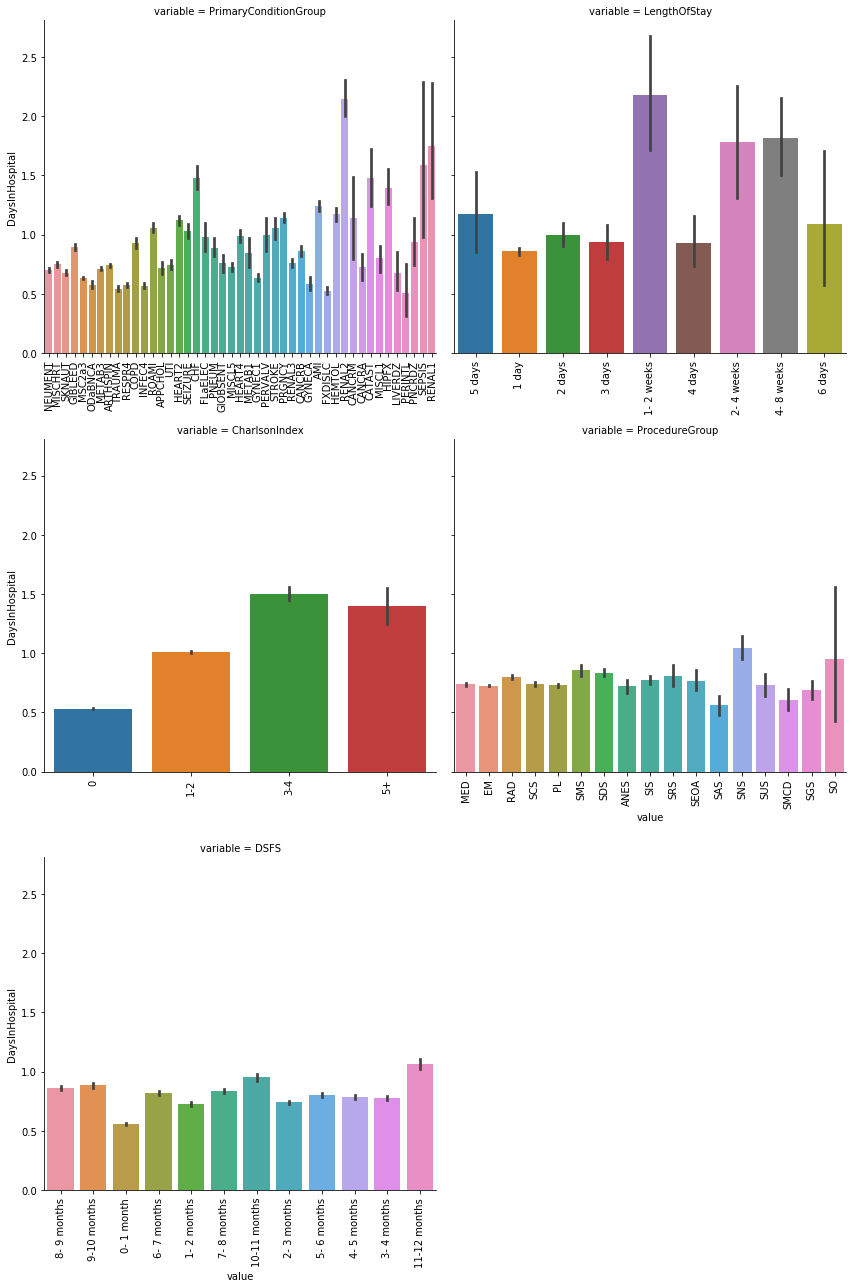

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

In [27]:
# 

def plot(x,y,**kwargs):
    sns.barplot(x,y)
    plt.xticks(rotation = 'vertical')
    plt.figure(figsize = (6,3))

grid = sns.FacetGrid(df, col = 'variable', col_wrap = 2, sharex = False, sharey = True, size = 6)
grid = grid.map(plot, 'value', 'DaysInHospital')

>Visualize average number of DaysInHospital for a given classm label, i.e. Charlson index = 0, PrimaryConditionGroup = SEPSIS

In [28]:
# validating how bar values are calculated - checks out

df[(df['variable'] == 'CharlsonIndex') & (df['value'] == '0')]['DaysInHospital'].mean()


0.5291606484996484

__Visualize and evaluate feature Days Since First Stay (DSFS)__  

In [29]:
# Days since first claim

dfClaims['DSFS'].value_counts()


0- 1 month      707721
1- 2 months     247343
2- 3 months     225216
3- 4 months     212214
5- 6 months     192000
4- 5 months     189001
6- 7 months     180662
7- 8 months     175191
8- 9 months     171878
9-10 months     151527
10-11 months    116328
11-12 months     47139
Name: DSFS, dtype: int64

([<matplotlib.axis.XTick at 0x1022096a0>],
 <a list of 1 Text xticklabel objects>)

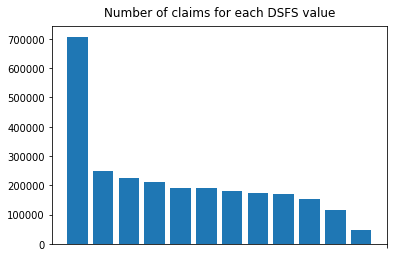

In [32]:
# Visualize DSFS value counts

x = dfClaims[(dfClaims['DSFS'].notnull())]['DSFS'].unique()
y = dfClaims[(dfClaims['DSFS'].notnull())]['DSFS'].value_counts(dropna = False)
plt.bar(x,y)
plt.title('Number of claims for each DSFS value',pad = 10)
plt.xticks('')


>Claims occuring within 0-1 months of service make up a sizeable portion of the claims. This makes sense because the first claim in a given year for each patient will have this '0-1 months' class value. This is true for patients who have their first service in January, December or any month in between.

__Visualize and evaluate feature Length of stay__  

In [35]:
#Lenght of stay

dfClaims['LengthOfStay'].value_counts()


1 day         56696
2 days         6485
3 days         3246
4 days         1473
1- 2 weeks     1143
2- 4 weeks      961
4- 8 weeks      903
5 days          510
6 days          179
26+ weeks         2
Name: LengthOfStay, dtype: int64

([<matplotlib.axis.XTick at 0x10a28cc88>],
 <a list of 1 Text xticklabel objects>)

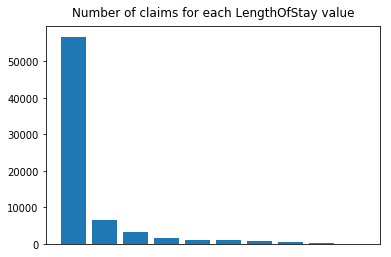

In [34]:
# Visualize length of stay value counts

x = dfClaims[(dfClaims['LengthOfStay'].notnull())]['LengthOfStay'].unique()
y = dfClaims[(dfClaims['LengthOfStay'].notnull())]['LengthOfStay'].value_counts(dropna = True)
plt.bar(x,y)
plt.title('Number of claims for each LengthOfStay value',pad = 10)
plt.xticks('')


>The majority of patients only stay in the hospital 1 day. I envision these encounters being a mix of a couple different types of patients. 1) relatively healthy patients who were admitted following relatively simply procedures, and were discharged quickly as expected. 2) Less healthy patients who were not especially sick, but sought out health care services (perhaps unnecessarily) and were admitted briefly for observation purposes, but discharged quickly as there were no immediate health care concerns. 

>Patients in the first category (healhy, in-and-out patients) are likely often receiving services that will be transitioned to the ambulatory setting in the future as medical advances make hospital unnecessary for certain simple, low-risk procedures. This has implications for long-term DaysInHospital projections, but not likely implications for short-term projections.

>Hospital stays 6 days or longer are very unusual

> It's interesting to note that the scale on the y-axis is much smaller for this column because this only includes encounters that had a length of stay. In other words, this only includes inpatient activity, not outpatient activity. This means that the majority of claims are outpatient claims.

__Visualize and evaluate feature Charlson index__  

In [38]:
# Charlson index
dfClaims['CharlsonIndex'].value_counts()


0      1356995
1-2    1256527
3-4      49479
5+        5989
Name: CharlsonIndex, dtype: int64

([<matplotlib.axis.XTick at 0x109cf7320>],
 <a list of 1 Text xticklabel objects>)

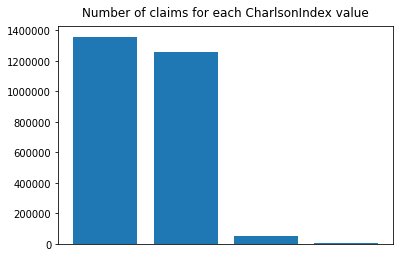

In [41]:
# Visualize Charlson index value counts

x = dfClaims[(dfClaims['CharlsonIndex'].notnull())]['CharlsonIndex'].unique()
y = dfClaims[(dfClaims['CharlsonIndex'].notnull())]['CharlsonIndex'].value_counts(dropna = False)
plt.bar(x,y)
plt.title('Number of claims for each CharlsonIndex value',pad = 10)
plt.xticks('')


>The vast majority of claims were submitted for patients with a Charlson Index of 0,1 or 2. By comparison, there are only a handful of patients with a CharlsonIndex of 5+. This makes sense given that these higher level index values are reserved for the sickest patients, and most individuals are not extremly sick.

> It's interesting that there is not a large difference between Charlson Index categories 0 and 1-2. This makes me wonder how many patients have a Charlson Index of 0 and how many have an index of 1-2.

([<matplotlib.axis.XTick at 0x109e08748>],
 <a list of 1 Text xticklabel objects>)

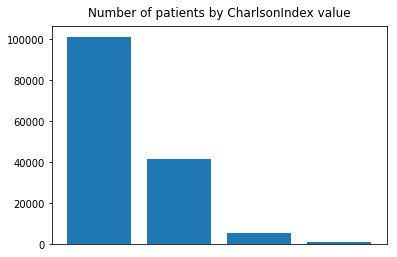

In [42]:
# note: A patient's Charlson Index can change from year to year, so the dataframe below
# has one record for each MemberID/CharlsonIndex combination.
# If a patient's index doesn't change, the patient will have one row
# On the other extreme, if a patient's index changes each year, the patient will have three record.

claimMbrs = dfClaims[['MemberID','CharlsonIndex']].drop_duplicates()

x = claimMbrs[(claimMbrs['CharlsonIndex'].notnull())]['CharlsonIndex'].unique()
y = claimMbrs[(claimMbrs['CharlsonIndex'].notnull())]['CharlsonIndex'].value_counts(dropna = False)
plt.bar(x,y)
plt.title('Number of patients by CharlsonIndex value',pad = 10)
plt.xticks('')

> This shows that the majority of patients have an index of 0. Considering this chart with the 'Number of claims for each CharlsonIndex value' chart above where the claim count is comparable between index 0 and 1-2 patients, it can be reasonably inferred that patients with an index of 1-2 incur more claims than index 0 patients.

# Custom tools

## Create claim processing tools

__General__

In [43]:
# 

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
    

__Claims__

In [44]:
# 

class ClaimNumAttributesAdder(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None): 
        charlson_idx_dt = {'0': 0, '1-2': 2, '3-4': 4, '5+': 6}
        X['CharlsonIndex'] = X['CharlsonIndex'].apply(lambda x: charlson_idx_dt[x])
        
        los_dt = {'1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6,
          '1- 2 weeks': 11, '2- 4 weeks': 21, '4- 8 weeks': 42, '26+ weeks': 180}
        X['LengthOfStay'] = X['LengthOfStay'].apply(lambda x: None if pd.isnull(x) else los_dt[x])
        
        X['PayDelay'] = X['PayDelay'].apply(lambda x: int(x) if x != '162+' else 162)
        X['DSFS'] = X['DSFS'].apply(lambda x: None if pd.isnull(x) else int(x[0]) + 1)
        return X
    

In [45]:
# 

class ClaimCatAttributesAdder(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = pd.get_dummies(data = X, columns = self.categorical_columns, drop_first = True)
        return X
    

In [46]:
#

class ClaimAggregater(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        agg_op_dt_claim = {
            'PayDelay': {
                'max_PayDelay': 'max',
                'min_PayDelay': 'min',
                'avg_PayDelay': 'mean'
            },
            'LengthOfStay': {
                'max_LOS': 'max',
                'min_LOS': 'min',
                'avg_LOS': 'mean'
            },
            'DSFS': {
                'max_dsfs': 'max',
                'min_dsfs': 'min',
                'avg_dsfs': 'mean'
            },
            'CharlsonIndex': {
                'max_CharlsonIndex': 'max',
                'min_CharlsonIndex': 'min',
                'avg_CharlsonIndex': 'mean'
            }
        }
        
        # add binary categorical columns to agg_op_dt_claim for groupby
        for i in X.columns[np.array(X.dtypes == 'uint8')]:
            agg_op_dt_claim['{0}'.format(i)] = {'Sum_{0}'.format(i) : 'sum'}
        
        result = X.groupby(['Year', 'MemberID']).agg(agg_op_dt_claim)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level = ['Year', 'MemberID'])
        result['range_dsfs'] = result['max_dsfs'] - result['min_dsfs']
        result['range_CharlsonIndex'] = result['max_CharlsonIndex'] - result['min_CharlsonIndex']
        return result

__Pharmacy__

In [47]:
# preprocess via pipeline

class DrugAttributesAdder(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):  
        dsfs_dt = {'0- 1 month': 15, '1- 2 months': 45, '2- 3 months': 75, '3- 4 months': 105, 
                   '4- 5 months': 135, '5- 6 months': 165, '6- 7 months': 195, '7- 8 months': 225, 
                   '8- 9 months': 255, '9-10 months': 285, '10-11 months': 315, '11-12 months': 345}
        X['DSFS'] = X['DSFS'].apply(lambda x: dsfs_dt[x])
        X['DrugCount'] = X['DrugCount'].apply(lambda x: 7 if x == '7+' else int(x))
        return X

class DrugAggregater(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        agg_op_dt_drug = {
            'DrugCount': {
                'max_DrugCount': 'max',
                'min_DrugCount': 'min',
                'avg_DrugCount': 'mean',
                'months_DrugCount': 'count'
            }
        }
        result = X.groupby(['Year', 'MemberID']).agg(agg_op_dt_drug)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=['Year', 'MemberID'])
        return result
    

__Lab__

In [48]:
# preprocess via pipeline

class LabAttributesAdder(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        dsfs_dt = {'0- 1 month': 15, '1- 2 months': 45, '2- 3 months': 75, '3- 4 months': 105, 
           '4- 5 months': 135, '5- 6 months': 165, '6- 7 months': 195, '7- 8 months': 225, 
           '8- 9 months': 255, '9-10 months': 285, '10-11 months': 315, '11-12 months': 345}
        X['DSFS'] = X['DSFS'].apply(lambda x: dsfs_dt[x])
        X['LabCountI'] = X['LabCount'].apply(lambda x: 10 if x == '10+' else int(x))
        return X

class LabAggregater(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        agg_op_dt_lab = {
            'LabCountI': {
                'max_LabCount': 'max',
                'min_LabCount': 'min',
                'avg_LabCount': 'mean',
                'months_LabCount': 'count'
            }
        }
        result = X.groupby(['Year', 'MemberID']).agg(agg_op_dt_lab)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=['Year', 'MemberID'])
        return result
    

__Membership__

In [49]:
# convert 'AgeAtFirstClaim' to numerical approximation

class MemberAttributesAdder(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None): 
        age_dt = {'40-49': 45, '70-79': 75, '50-59': 55, '60-69': 65, '30-39': 35,
          '10-19': 15, '0-9': 5, '20-29': 25, '80+': 85}
        X['AgeAtFirstClaim'] = X['AgeAtFirstClaim'].apply(lambda x: None if pd.isnull(x) else age_dt[x])
        return X
    
class MemberLabelEncoder(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        X['Sex'] = np.where(X['Sex'].isnull(),'NaN',X['Sex'])
        self.le = LabelEncoder()
        self.le.fit(X['Sex'])
        self.classes = self.le.classes_
        return self
    
    def transform(self, X, y = None): 
        X['Sex'] = np.where(X['Sex'].isnull(),'NaN',X['Sex'])
        X['Sex'] = self.le.transform(X['Sex'])
        return X

class DropOneColumn(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        classes = memberCatPipeline.named_steps.encoder.classes
        X = pd.DataFrame(X[:,:2], columns=classes[:2])
        return X
    

## Model evaluation tools

__Tool for performing GridSearchCV with multiple models__

In [50]:
class EstimatorSelectionHelper:
    
    
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError('Some estimators are missing parameters: {0}'.format(missing_params))
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    # Full GridSearchCV
    def fitGs(self, X, y, cv = 5, n_jobs = 1, verbose = 0, scoring = None, refit = True):
        for key in self.keys:
            print('Running GridSearchCV for {0}'.format(key))
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model
                              ,params
                              ,cv = cv
                              ,n_jobs = n_jobs
                              ,verbose = verbose
                              ,scoring = scoring
                              ,refit = refit
                              ,return_train_score = True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
        return gs
    
    # RandomizedSearchCV
    def fitRgs(self, X, y, cv = 5, n_jobs = 1, verbose = 0, scoring = None, refit = True, n_iter = 15):
        for key in self.keys:
            print('Running RandomizedSearchCV for {0}'.format(key))
            model = self.models[key]
            params = self.params[key]        
            rgs = RandomizedSearchCV(model
                                    ,params
                                    ,cv = cv
                                    ,n_jobs = n_jobs
                                    ,verbose = verbose
                                    ,scoring = scoring
                                    ,refit = refit
                                    ,return_train_score = True
                                    ,n_iter = n_iter)
            rgs.fit(X,y)
            self.grid_searches[key] = rgs    
        return rgs
        
    def scoreSummary(self, sort_by = 'mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key
                 ,'min_score': min(scores)
                 ,'max_score': max(scores)
                 ,'mean_score': np.mean(scores)
                 ,'std_score': np.std(scores)
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            #print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = 'split{}_test_score'.format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis = 1).T.sort_values([sort_by], ascending = False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


__Model comparison t-test__ 

In [51]:
#

def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Data transformation and feature engineering

__Claims data__

In [81]:
#

categorical_columns = ['Specialty','PlaceSvc','PrimaryConditionGroup','ProcedureGroup']
claimPipeline = Pipeline([
    ('claimAdder', ClaimNumAttributesAdder())
    ,('dummies', ClaimCatAttributesAdder(categorical_columns))
    ,('claimAggregater', ClaimAggregater())
    ])
dfClaimsAggregated = claimPipeline.transform(dfClaims)


__Drug data__

In [82]:
#

drugPipeline = Pipeline([
    ('drugAdder', DrugAttributesAdder()),
    ('drugAggregater', DrugAggregater())
    ])
dfDrugCountAggregated = drugPipeline.transform(dfDrugCount)


__Lab data__

In [83]:
#

labPipeline = Pipeline([
    ('labAdder', LabAttributesAdder()),
    ('labAggregater', LabAggregater())
    ])
dfLabCountAggregated = labPipeline.transform(dfLabCount)


__Member data__

In [84]:
#

dfMembersAge = dfMembers.drop('Sex',axis = 1)
dfMembersSex = pd.DataFrame(dfMembers['Sex'],columns = ['Sex'])

adder = MemberAttributesAdder()
dfMembers = adder.fit_transform(dfMembersAge)

memberCatPipeline = Pipeline([('encoder', MemberLabelEncoder()),
                                ('ohe', OneHotEncoder(sparse = False)),
                                ('dropcol', DropOneColumn())
                               ])
dfMembersSex = memberCatPipeline.fit_transform(dfMembersSex)

# rejoin Age and Sex columns
dfMembers[['F','M']] = dfMembersSex


__Merge data__

In [85]:
# 

dfMerged = pd.concat([dfTargetY2, dfTargetY3])
dfMerged = dfMerged.merge(dfMembers
                            ,how = 'left'
                            ,on = 'MemberID')
dfMerged = dfMerged.merge(dfClaimsAggregated
                            ,how = 'left'
                            ,on = ['MemberID', 'Year'])
dfMerged = dfMerged.merge(dfDrugCountAggregated
                            ,how = 'left'
                            ,on = ['MemberID', 'Year'])
dfFinal = dfMerged.merge(dfLabCountAggregated
                            ,how = 'left'
                            ,on = ['MemberID', 'Year'])

dfFinalY1 = dfFinal[dfFinal['Year'] == 'Y1']
dfFinalY1.set_index('MemberID', inplace = True)

dfFinalY2 = dfFinal[dfFinal['Year'] == 'Y2']
dfFinalY2.set_index('MemberID', inplace = True)


__Train/test split, impute, feature scaling pipeline__

In [86]:


def splitPrep(dataset):
    df_train, df_test = train_test_split(dataset, test_size = 0.3, random_state = 42)
    
    y_train = df_train['label']
    y_test = df_test['label']
    
    X_train = df_train.drop(['label'], axis = 1)
    X_test = df_test.drop(['label'], axis = 1)
    
    allCols = X_train.columns.values
    categorical_columns = ['ClaimsTruncated','F','M']
    index = [np.argwhere(allCols == i)[0][0] for i in categorical_columns]
    numeric_columns = np.delete(allCols, index)

    numPipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', Imputer(strategy = 'median')),
        ('std_scaler', StandardScaler()),
    ])

    catPipeline = Pipeline([
        ('selector', DataFrameSelector(categorical_columns)),
    ])

    fullPipeline = FeatureUnion(transformer_list = [
        ('numPipeline', numPipeline),
        ('catPipeline', catPipeline),
    ])    
    
    X_train = fullPipeline.fit_transform(X_train)
    X_test = fullPipeline.transform(X_test)
    
    return X_train, X_test, y_train, y_test, numeric_columns, categorical_columns


## Feature engineering - delta columns

* Rationale - A year over year change of a certain feature may indicate a change in health status or a change in how a patient interacts with the health care system. For example, if cumulative LOS increases from one year to the next, this likely indicates a detrimental change in health status and portends a higher number of Days In Hospital in the future. Other deltas are more ambiguous, such as number of EM (office) visits. If a patient is seeing a provider on an outpatient basis more frequently, this indicates a change in how a person interacts with the health system. While it could be said that more touch points with the health care system are a bad thing, it could also indicate that a patient's condition is being managed more effectively on an outpatient basis, and therefore could lead to fewer inpatient admissions in the future.

* Approach - To determine the deltas, I calculate the various changes from the Year 1 claims to the Year 2 claims. Using this approach, the claims for Year 2 are the key observations (rather than both Year 1 and Year 2), so the delta columns are features added to the Year 2 claims data. The goal is the predict the DaysInHospital in Year 3.
        
* Considerations:
    * Year 1 to Year 2 deltas can be used to calculate Year 3 Days in Hospital, but Year 1 to Year 2 deltas cannot be used to calculate Year 2 Days in Hospital. Similarly, Year 2 to Year 3 deltas cannot be used to calculate Year 3 DaysInHospital. These erroneous approaches incorporate future data before we would know about it in practice. The question to keep in mind is "what information can I use to determine the DaysInHospital for _next_ year?"
    * To implement these delta features, I am limited the observations and predictions in Year 2. I have Year 1 to Year 2 deltas, but not 'Year 0' to Year 1 deltas. The only alternative would be to make the values for the 'Year 0' to Year 1 deltas zeros throughout, which seem dubious. Therefore, making predictions for the number of Days In Hospital for the year one claimants is not feasible. However, there are still over 71,000 members submitting claims in Year 2, which provides a substantial sample size. This set up is also very similar to the original Kaggle competition, where Year 3 claims (potentially with Year 2 deltas) were used to predict Year 4 Days In Hospital.
    * The point above addresses the macro issue of missing claims for an entire year, but not the micro issue of missing a years worth of claims for a single individual (or a group of individuals). In this dataset, this arises when a Year 2 claimant did not have any claims in Year 1. In this case, the deltas are equal to the Year 2 values because the Year 1 'values' for this patient do not exist and are therefore zero. This is less than ideal but is an accepted weakness of the approach because this is a realistic scenario. In practice, a member in this scenario either submitted zero claims (which a health plan would know and be able to incorporate) or the member joined the health plan recently and has zero claim history. 


__Pivot, separate and subtract Y1 from Y2__

In [88]:
deltaCols = dfFinal.columns.values[8:]
dfDeltas = pd.pivot_table(data = dfFinal
               ,index = ['MemberID']
               ,columns = ['Year']
               ,values = deltaCols)
multiIndex = dfDeltas.columns
singleIndex = pd.Index([i[0] + ' ' + i[1] for i in multiIndex.tolist()])
dfDeltas.columns = singleIndex
dfDeltas.reset_index(inplace = True)
dfDeltas.fillna(0, inplace = True)


In [89]:
y1Cols = [col for col in dfDeltas.columns if 'Y1' in col]
y1Cols.append('MemberID')
dfDeltasY1 = dfDeltas[y1Cols]
dfDeltasY1.set_index('MemberID', inplace = True)
simpleCols = [i.split()[0] for i in dfDeltasY1.columns]
dfDeltasY1.columns = simpleCols


In [90]:
y2Cols = [col for col in dfDeltas.columns if 'Y2' in col]
y2Cols.append('MemberID')
dfDeltasY2 = dfDeltas[y2Cols]
dfDeltasY2.set_index('MemberID', inplace = True)
simpleCols = [i.split()[0] for i in dfDeltasY2.columns]
dfDeltasY2.columns = simpleCols


In [91]:
dfDeltas = dfDeltasY2.sub(dfDeltasY1)
dfDeltas.columns = ['Delta_' + i for i in dfDeltas.columns]


In [92]:
dfFinalY2Delta = pd.merge(dfFinalY2, dfDeltas, left_index = True, right_index = True)
dfFinalY2Delta = dfFinalY2Delta.drop(['DaysInHospital','Year'], axis = 1)
print(dfFinalY2Delta.shape)


(71435, 205)


## Train/test split

In [93]:
X_train, X_test, y_train, y_test, numeric_columns, categorical_columns = splitPrep(dataset = dfFinalY2Delta)

print('X_train shape: {0}'.format(X_train.shape))
print('y_train shape: {0}\n'.format(y_train.shape))
print('X_test shape: {0}'.format(X_test.shape))
print('y_test shape: {0}'.format(y_test.shape))


X_train shape: (50004, 204)
y_train shape: (50004,)

X_test shape: (21431, 204)
y_test shape: (21431,)


# Additional EDA

__Feature selection tools__

In [94]:


def selectKBestRef(dataFrame, target, k = 5):
    featSelector = SelectKBest(f_regression, k = k)
    _ = featSelector.fit(dataFrame.drop(target, axis = 1), dataFrame[target])
    
    featScores = pd.DataFrame()
    featScores['F score'] = featSelector.scores_
    featScores['P value'] = featSelector.pvalues_
    featScores['Support'] = featSelector.get_support()
    featScores['Attribute'] = dataFrame.drop(target, axis = 1).columns
    
    return featScores

def indicesOfTopK(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, featureImportance, k):
        self.featureImportance = featureImportance
        self.k = k
    
    def fit(self, X, y = None):
        self.featureIndices_ = indicesOfTopK(self.featureImportance, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.featureIndices_]
    

In [95]:
# 

df = pd.DataFrame(X_train, columns = np.append(numeric_columns,categorical_columns))
df['label'] = y_train
df['label'].fillna(0, inplace = True)

featScores = selectKBestRef(df, 'label', k = 10)

featScoresSorted = featScores.sort_values(['F score', 'P value'], ascending = [False, False])
print('Feature Score for a linear regression using correlation \n')
print(featScoresSorted[featScoresSorted['Support'] == True][:10])

featureFScores = featScores[['F score']].values.flatten()


Feature Score for a linear regression using correlation 

     F score  P value  Support                                Attribute
192 5.433393 0.019759     True                      Delta_min_DrugCount
194 5.247394 0.021984     True                       Delta_min_LabCount
31  4.440450 0.035102     True        Sum_PrimaryConditionGroup_APPCHOL
22  4.045447 0.044296     True             Sum_Specialty_Rehabilitation
177 3.656103 0.055870     True       Delta_Sum_Specialty_Rehabilitation
94  3.515306 0.060810     True                            min_DrugCount
108 3.097268 0.078430     True  Delta_Sum_PrimaryConditionGroup_APPCHOL
182 2.934376 0.086718     True                       Delta_avg_LabCount
96  2.824003 0.092871     True                         months_DrugCount
180 2.432830 0.118825     True                      Delta_avg_DrugCount


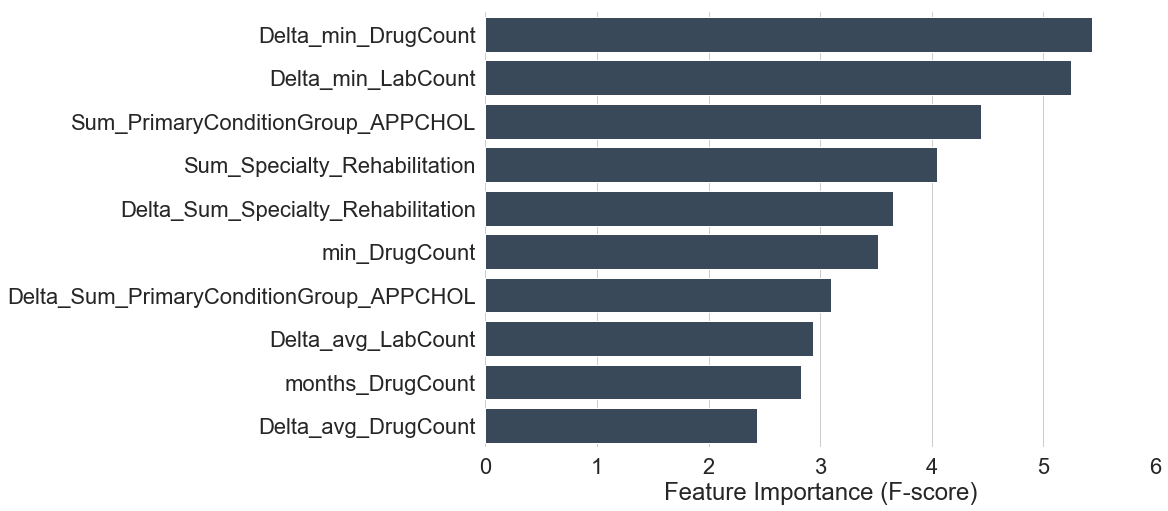

In [96]:
#

sortedNames = np.array(featScoresSorted)[:10, 3]
sortedImportances = np.array(featScoresSorted)[:10, 0]

sns.set(style = 'whitegrid', font_scale = 2)
f, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x = sortedImportances
            ,y = sortedNames
            ,orient = 'h'
            ,color = '#34495e')

#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 6)
       ,ylabel = ''
       ,xlabel = 'Feature Importance (F-score)')
sns.despine(left = True, bottom = True)


>6 of the top 10 most important features based on F-score are delta column. Leading the group are Delta_min_DrugCount and Delta_min_LabCount, which suggest that changes in the minimum number of labs and drugs received from year to year are related to Days In Hospital. Directionality cannot be drawn directly from the F-score, but intuitively one would assume that patients with increasing minimums are spending more time in the hospital the following year, while patients with decreasing minimums are spending less time in the hospital the following year

# Build models

## Define models, parameter grid

In [97]:
models = {
    'Lasso' : Lasso()
    ,'Ridge' : Ridge()
    ,'AdaBoostRegressor': AdaBoostRegressor()
    ,'GradientBoostingRegressor': GradientBoostingRegressor()
    ,'RandomForestRegressor': RandomForestRegressor()
    ,'XGBoost' : XGBRegressor()
}

params = {
        'Lasso': {
                                'alpha': np.arange(1e-6, 1000, 0.05)
                                }
        ,'Ridge': {
                                'alpha': np.arange(1e-6, 1000, 0.05)
                                }
        ,'AdaBoostRegressor':  {
                                'n_estimators': np.arange(200, 2000, 100)
                                }
        ,'GradientBoostingRegressor': {
                                'n_estimators': np.arange(200, 2000, 100)
                                ,'max_features' : ['auto', 'sqrt']
                                ,'max_depth': np.arange(2, 10, 2)
                                ,'min_samples_split': np.arange(2, 40, 2)
                                ,'min_samples_leaf': np.arange(2, 40, 2)
                                }
        ,'RandomForestRegressor' : {
                                'n_estimators': np.arange(200, 2000, 100)
                                ,'max_features' : ['auto', 'sqrt']
                                ,'max_depth': np.arange(2, 10, 2)
                                ,'min_samples_split': np.arange(2, 40, 2)
                                ,'min_samples_leaf': np.arange(2, 40, 2)
                                ,'bootstrap': [True, False]
                                }
        ,'XGBoost' : {
                                'n_estimators': np.arange(200, 2000, 100)                    
                                ,'max_depth' : range(2, 10, 2)
                                ,'min_child_weight' : range(1, 6, 2)
                                ,'gamma' : [i / 10.0 for i in range(0, 6)]
                                ,'subsample' : [i /10.0 for i in range(6, 10)]
                                ,'colsample_bytree' : [i / 10.0 for i in range(6, 10)]
                                ,'reg_lambda' : [1e-5, 1e-2, 0.1, 1, 100]
        }
}


## Model selection - RandomizedSearchCV

In [ ]:
helper = EstimatorSelectionHelper(models, params)

gridSearch = helper.fitRgs(X_train
                ,y_train
                ,n_iter = 10
                ,verbose = 4
                ,scoring = 'neg_mean_squared_error')


>Final phase updates - Increased n_iter to 10. Increased KFold to 5 (in the code for the Class defined above).

__CV results__

In [34]:
scores = helper.scoreSummary()
scores[['min_score', 'mean_score', 'max_score']] = scores[['min_score', 'mean_score', 'max_score']].applymap(lambda x: np.round(np.sqrt(-x), 6))
scores.fillna('')


,estimator,min_score,mean_score,max_score,std_score,alpha,bootstrap,colsample_bytree,gamma,max_depth,max_features,min_child_weight,min_samples_leaf,min_samples_split,n_estimators,reg_lambda,subsample
41,RandomForestRegressor,0.455356,0.450158,0.441305,0.004922,,True,,,8,auto,,26,18,800,,
31,GradientBoostingRegressor,0.457348,0.451600,0.442015,0.005345,,,,,4,sqrt,,34,18,700,,
37,GradientBoostingRegressor,0.459362,0.452974,0.441853,0.005949,,,,,2,auto,,12,38,1100,,
57,XGBoost,0.459447,0.454000,0.443594,0.005543,,,0.700000,0.400000,2,,5,,,1100,1,0.800000
17,Ridge,0.461027,0.454524,0.444410,0.006032,340.150001,,,,,,,,,,,
16,Ridge,0.461031,0.454524,0.444429,0.006025,436.350001,,,,,,,,,,,
11,Ridge,0.461047,0.454535,0.444455,0.006019,556.600001,,,,,,,,,,,
13,Ridge,0.461063,0.454546,0.444475,0.006015,635.700001,,,,,,,,,,,
15,Ridge,0.461065,0.454548,0.444477,0.006015,645.000001,,,,,,,,,,,
18,Ridge,0.461091,0.454568,0.444504,0.006011,750.000001,,,,,,,,,,,


## Visualize feature importance

In [98]:
#

rfrFinal = RandomForestRegressor(bootstrap = True
                                ,max_depth = 8
                                ,max_features = 'auto'
                                ,min_samples_leaf = 26
                                ,min_samples_split = 18
                                ,n_estimators = 800)
rfrFinal.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=26, min_samples_split=18,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

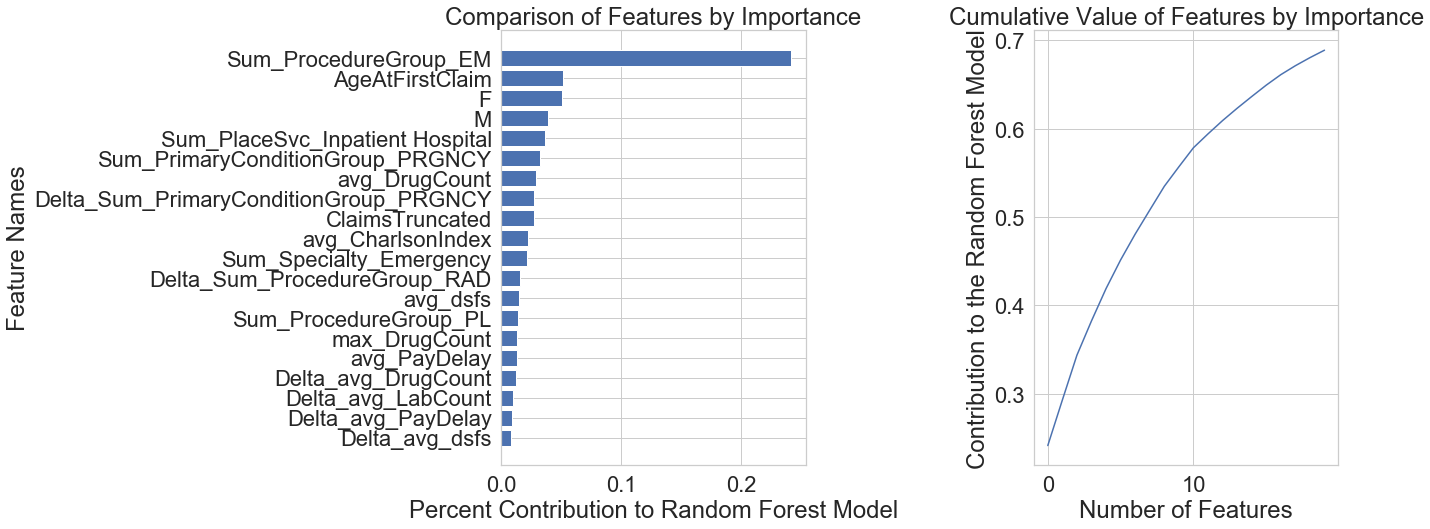

In [99]:
#

z = list(zip(rfrFinal.feature_importances_, np.append(numeric_columns,categorical_columns)))
z = sorted(z, key = lambda tup: tup[0], reverse = True)[:20]

# plot horizontal bar by feature importance
z.sort(reverse = False)
values, labels = zip(*z)
plt.figure(figsize = (15,8))
plt.subplot(121)
plt.barh(labels, values)
plt.xlabel('Percent Contribution to Random Forest Model')
plt.ylabel('Feature Names')
plt.title('Comparison of Features by Importance')

# reverse sorting (for a more intuitive aesthetic) and plot the cumulative value of features
plt.subplot(122)
z.sort(reverse = True)
values, labels = zip(*z)
plt.plot(np.cumsum(values))
plt.ylabel('Contribution to the Random Forest Model')
plt.xlabel('Number of Features')
plt.title('Cumulative Value of Features by Importance');

plt.subplots_adjust(wspace = .75)


In [102]:
X_train.shape

(50004, 204)

## Discussion
The best algorithm was the RandomForestRegressor. The best hyperparameters are:
    Best parameter: {'n_estimators': 800, 'min_samples_split': 18, 'min_samples_leaf': 26, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}

By far the most informative feature is the Sum_ProcedureGroup_EM column, followed by three columns that describe gender and the AgeAtFirstClaim, and the fifth most important column is the sum of inpatient hospital visits. These five columns, accounting for only 2.5% of the total number of columns, account for nearly 42% of the predictive value. 

# Model evaluation

__Prepare data__

In [104]:
dfMerged = pd.concat([dfTargetY2, dfTargetY3])
dfMerged = dfMerged.merge(dfMembers
                            ,how = 'left'
                            ,on = 'MemberID')
dfMerged = dfMerged.merge(dfClaimsAggregated
                            ,how = 'left'
                            ,on = ['MemberID', 'Year'])
dfMerged = dfMerged.merge(dfDrugCountAggregated
                            ,how = 'left'
                            ,on = ['MemberID', 'Year'])
dfFinal = dfMerged.merge(dfLabCountAggregated
                            ,how = 'left'
                            ,on = ['MemberID', 'Year'])

dfFinalY1 = dfFinal[dfFinal['Year'] == 'Y1']
dfFinalY1.set_index('MemberID', inplace = True)

dfFinalY2 = dfFinal[dfFinal['Year'] == 'Y2']
dfFinalY2.set_index('MemberID', inplace = True)

deltaCols = dfFinal.columns.values[8:]
dfDeltas = pd.pivot_table(data = dfFinal
               ,index = ['MemberID']
               ,columns = ['Year']
               ,values = deltaCols)
multiIndex = dfDeltas.columns
singleIndex = pd.Index([i[0] + ' ' + i[1] for i in multiIndex.tolist()])
dfDeltas.columns = singleIndex
dfDeltas.reset_index(inplace = True)
dfDeltas.fillna(0, inplace = True)

y1Cols = [col for col in dfDeltas.columns if 'Y1' in col]
y1Cols.append('MemberID')
dfDeltasY1 = dfDeltas[y1Cols]
dfDeltasY1.set_index('MemberID', inplace = True)
simpleCols = [i.split()[0] for i in dfDeltasY1.columns]
dfDeltasY1.columns = simpleCols

y2Cols = [col for col in dfDeltas.columns if 'Y2' in col]
y2Cols.append('MemberID')
dfDeltasY2 = dfDeltas[y2Cols]
dfDeltasY2.set_index('MemberID', inplace = True)
simpleCols = [i.split()[0] for i in dfDeltasY2.columns]
dfDeltasY2.columns = simpleCols

dfDeltas = dfDeltasY2.sub(dfDeltasY1)
dfDeltas.columns = ['Delta_' + i for i in dfDeltas.columns]

dfFinalY2Delta = pd.merge(dfFinalY2, dfDeltas, left_index = True, right_index = True)
dfFinalY2Delta = dfFinalY2Delta.drop(['DaysInHospital','Year'], axis = 1)
print(dfFinalY2Delta.shape)


X_train, X_test, y_train, y_test, numeric_columns, categorical_columns = splitPrep(dataset = dfFinalY2Delta)

print('X_train shape: {0}'.format(X_train.shape))
print('y_train shape: {0}\n'.format(y_train.shape))
print('X_test shape: {0}'.format(X_test.shape))
print('y_test shape: {0}'.format(y_test.shape))


(71435, 205)


### Baseline model

In [109]:
model = DummyRegressor(strategy = 'mean')
cv = ShuffleSplit(n_splits = 30, test_size = 0.3, random_state = 1)
baseline_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error')
baseline_train_score = np.sqrt(-baseline_scores.mean())

model.fit(X_train, y_train)
baseline_train_predict = model.fit(X_train, y_train)

baseline_test_predict = model.predict(X_test)
baseline_test_score = np.sqrt(mean_squared_error(y_test, baseline_test_predict))

results = pd.DataFrame(columns = ['ExpID', 'Train RMSE (Mean)', 'Test RMSE', 'p-value'])
results.loc[0] = ['Baseline Model (Mean)', round(baseline_train_score, 4), round(baseline_test_score, 4), "---"]

results


,ExpID,Train RMSE (Mean),Test RMSE,p-value
0,Baseline Model (Mean),0.476000,0.470100,---


### Baseline vs. Phase 2 best model

Best algorithm: RandomForestRegressor

Best parameters: {'n_estimators': 50, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}

In [107]:
rfrPhase2 = RandomForestRegressor(bootstrap = True
                                ,max_depth = 8
                                ,max_features = 'sqrt'
                                ,min_samples_leaf = 6
                                ,min_samples_split = 18
                                ,n_estimators = 50)

regressors = [('RandomForest, Phase 2 best, delta data set', rfrPhase2)]

for idx, (name, regressor) in enumerate(regressors):
    cv = ShuffleSplit(n_splits = 30, test_size = 0.3, random_state = 1)
    rfrPhase2_cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error')
    train_score = np.sqrt(-rfrPhase2_cv_scores.mean())
    model = regressor
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, test_preds))
    
    p_value = ttest(baseline_scores, rfrPhase2_cv_scores)
    results.loc[len(results)] = [name, round(train_score, 4), round(test_score, 4), round(p_value, 4)]
    

The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (-38.72, 0.00067)
Machine learning pipeline B is better than A


In [108]:
results


,ExpID,Train RMSE (Mean),Test RMSE,p-value
0,Baseline Model (Mean),0.474700,0.470100,---
1,"RandomForest, Phase 2 best, delta data set",0.454700,0.451200,0.000700


> Remarks - Phase 2 best model is significantly better than the baseline model, per the related-sample ttest

### Final model vs. Phase 2 best model

Best algorithm: RandomForestRegressor.

Best parameters: {'n_estimators': 800, 'min_samples_split': 18, 'min_samples_leaf': 26, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}
 

In [109]:
#

rfrFinal = RandomForestRegressor(bootstrap = True
                                ,max_depth = 8
                                ,max_features = 'auto'
                                ,min_samples_leaf = 26
                                ,min_samples_split = 18
                                ,n_estimators = 800)

regressors = [('RandomForest, Final, delta data set', rfrFinal)]

for idx, (name, regressor) in enumerate(regressors):
    cv = ShuffleSplit(n_splits = 30, test_size = 0.3, random_state = 1)
    final_cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error')
    train_score = np.sqrt(-final_cv_scores.mean())
    model = regressor
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, test_preds))
    
    p_value = ttest(rfrPhase2_cv_scores, final_cv_scores)
    results.loc[len(results)] = [name, round(train_score, 4), round(test_score, 4), round(p_value, 4)]
    print('Completed run {0}'.format(idx))
    

The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (-13.73, 0.00526)
Machine learning pipeline B is better than A
Completed run 0


In [110]:
#

results


,ExpID,Train RMSE (Mean),Test RMSE,p-value
0,Baseline Model (Mean),0.474700,0.470100,---
1,"RandomForest, Phase 2 best, delta data set",0.454700,0.451200,0.000700
2,"RandomForest, Final, delta data set",0.449900,0.446400,0.005300


> Remarks - The final model is significantly better than the best model from phase 2 model, per the related-sample ttest